 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import torch
import torchvision


from torch import nn
from torch import optim
from tqdm.auto import tqdm
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

Скачаем обучающую и контрольную выборки.

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [ ]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = {
  0: "T-shirt/top",
  1: "Trouser",
  2: "Pullover",
  3: "Dress",
  4: "Coat", 
  5: "Sandal", 
  6: "Shirt",
  7: "Sneaker",
  8: "Bag",
  9: "Ankle boot"
}

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

### Проверим количество картинок

In [ ]:
print("Amount of images in train:", len(trainset))
print("Amount of images in test: ", len(testset))

Amount of images in train: 60000
Amount of images in test:  10000


### Проверим равномерность распределения

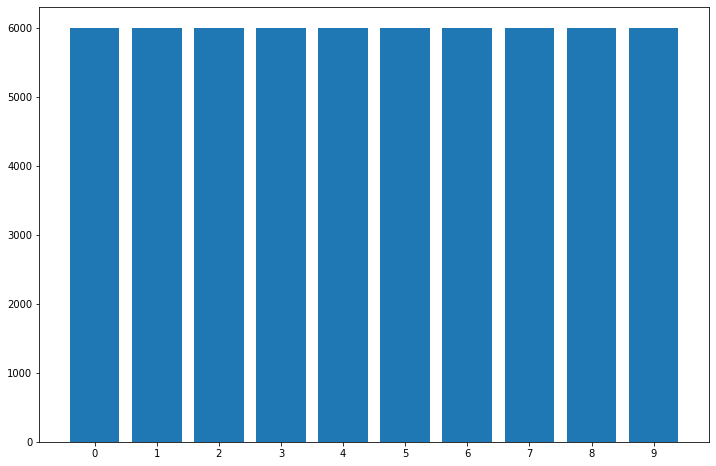

In [ ]:
unique_train_set, counts_train_set = np.unique(trainloader.dataset.targets, return_counts=True)
plt.figure(figsize=(12, 8))
plt.bar(unique_train_set, counts_train_set)
plt.xticks(np.arange(0, 10, 1))
plt.show()

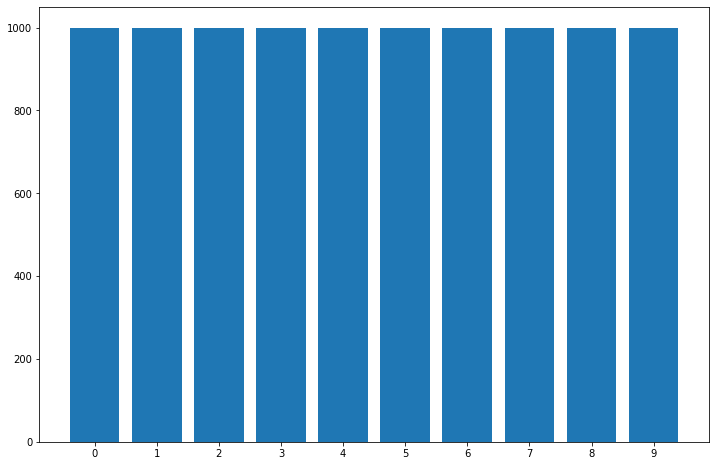

In [ ]:
unique_test_set, counts_test_set = np.unique(testloader.dataset.targets, return_counts=True)
plt.figure(figsize=(12, 8))
plt.bar(unique_test_set, counts_test_set)
plt.xticks(np.arange(0, 10, 1))
plt.show()

### Выведем несколько картинок


Item in the picture: Coat


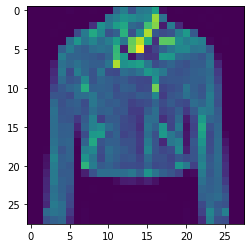


Item in the picture: Shirt


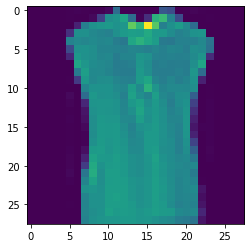


Item in the picture: Ankle boot


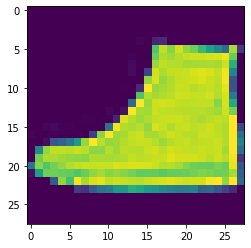

In [ ]:
pictures_to_show = np.random.randint(6_000, size=3)
for index in pictures_to_show:
    print(f"\nItem in the picture: {classes[trainset.targets[index].item()]}")
    plt.imshow(trainset.data[index])
    plt.show()

### Реализуем функции для удобства

In [ ]:
print(torch.cuda.is_available())
torch.cuda.synchronize()

True


In [ ]:
def fit(model, optimizer, loss_function, epochs):
    loss_values = np.array([])

    for epoch in tqdm(range(epochs)):
        for index, (x, y) in enumerate(trainloader):
            x, y = x.cuda(), y.cuda()
            optimizer.zero_grad()

            pred = model(x)
            loss = loss_function(pred, y)
            loss.backward()
            optimizer.step()

            if index == 14999:
                loss_values = np.append(loss_values, loss.item())

    return loss_values

In [ ]:
def plot_loss_function(loss_values, epochs):
    plt.figure(figsize=(10, 10))
    plt.plot(np.array(loss_values))
    plt.title("Step-wise Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(np.arange(0, epochs + 1, 1))
    plt.show()

In [ ]:
def report(model, test_dataloader):
    y_pred_arr = np.array([])
    y_test_arr = np.array([])

    model.eval()

    with torch.no_grad():
        for x, y in test_dataloader:
            x, y = x.cuda(), y.cuda()
            outputs = model(x)

            y_pred = torch.argmax(outputs, dim=1).detach()
            y_pred_arr = np.append(y_pred_arr, y_pred.cpu())
            y_test_arr = np.append(y_test_arr, y.cpu())

    return classification_report(y_pred=y_pred_arr, y_true=y_test_arr)

### Реализуем MLP

Я использовал следущие параметры:

1.   Количество эпох: 20
2.   Коэффициент обучения: 10 ** (-4)
3.   Функция активации на скрытых слоях: LeakyReLU
4.   Количество скрытых слоёв: 2
5.   Размер выборки: 4
6.   Функция потерь: Cross Entropy Loss
7.   Оптимайзер: Adam Algorithm
8.   Процент dropout: 20%

In [ ]:
LEARNING_RATE = 10 ** (-4)
INPUT_DIMENSIONS = 784
HIDDEN_DIMENSIONS = (128, 64)
OUTPUT_DIMENSIONS = 10

class MLP(nn.Module):
    def __init__(self, input_dimensions, hidden_dimensions, output_dimensions):
        super(MLP, self).__init__()
        self._input_dimensions = input_dimensions
        self._hidden_dimensions = hidden_dimensions
        self._output_dimensions = output_dimensions
        self.layer1 = nn.Sequential(
            nn.Linear(self._input_dimensions, self._hidden_dimensions[0]),
            nn.BatchNorm1d(self._hidden_dimensions[0]),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(self._hidden_dimensions[0], self._hidden_dimensions[1]),
            nn.BatchNorm1d(self._hidden_dimensions[1]),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )

        self.fc = nn.Sequential(
            nn.Linear(self._hidden_dimensions[1], self._output_dimensions)
        )
        
       
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.fc(x)
        return x

In [ ]:
mlp = MLP(INPUT_DIMENSIONS, HIDDEN_DIMENSIONS, OUTPUT_DIMENSIONS)
mlp.cuda()
mlp.train()

loss_function_mlp = nn.CrossEntropyLoss()
optimizer_mlp = optim.Adam(mlp.parameters(), lr=LEARNING_RATE)

### Тестирование

In [ ]:
loss_values_mlp = fit(mlp, optimizer_mlp, loss_function_mlp, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

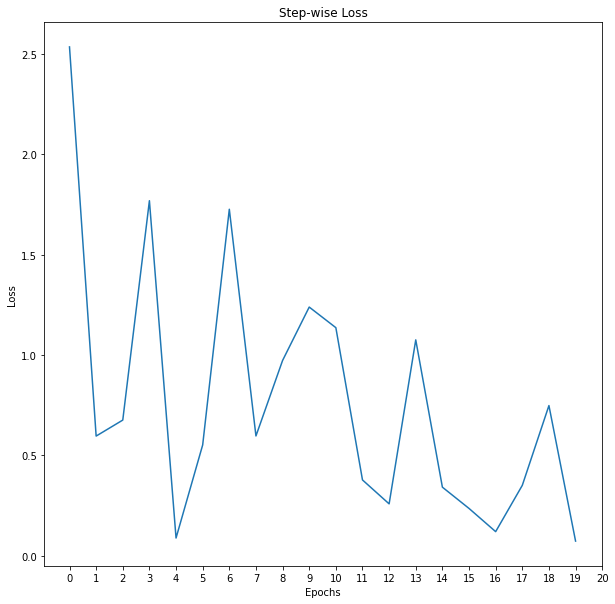

In [ ]:
plot_loss_function(loss_values_mlp, 20)

In [ ]:
report_mlp = report(mlp, testloader)
print(report_mlp)

              precision    recall  f1-score   support

         0.0       0.77      0.86      0.81      1000
         1.0       0.98      0.97      0.98      1000
         2.0       0.73      0.82      0.77      1000
         3.0       0.85      0.90      0.87      1000
         4.0       0.80      0.74      0.77      1000
         5.0       0.98      0.91      0.94      1000
         6.0       0.71      0.56      0.63      1000
         7.0       0.90      0.94      0.92      1000
         8.0       0.96      0.97      0.97      1000
         9.0       0.93      0.95      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



### Реализуем CNN

Я использовал следущие параметры:

1.   Количество эпох: 20
2.   Коэффициент обучения: 10 ** (-4)
3.   Функция активации на скрытых слоях: ReLU
4.   Количество скрытых слоёв: 1
5.   Размер выборки: 4
6.   Функция потерь: Cross Entropy Loss
7.   Оптимайзер: Stochastic Gradient Descend

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 6 * 6, 600),
            nn.ReLU(),
            nn.Linear(600, 120),
            nn.ReLU(),
            nn.Linear(120, 10)
        )
        
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)  
        return x

In [ ]:
cnn = CNN()
cnn.cuda()
cnn.train()

loss_function_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.SGD(cnn.parameters(), lr=LEARNING_RATE)

In [ ]:
loss_values_cnn = fit(cnn, optimizer_cnn, loss_function_cnn, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

### Тестирование

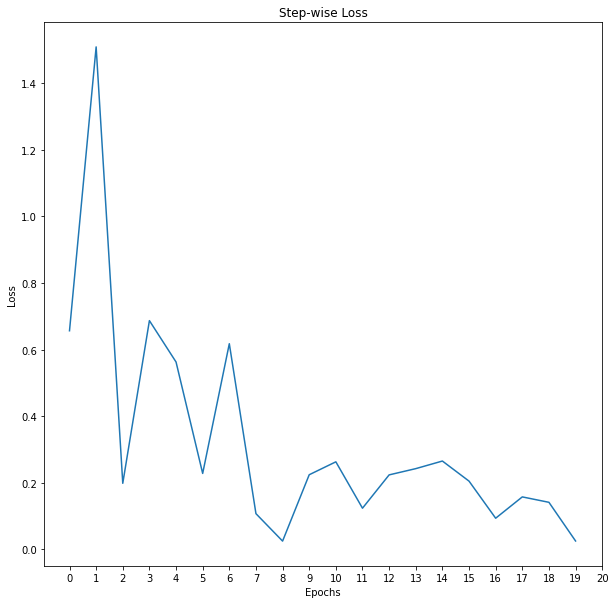

In [ ]:
plot_loss_function(loss_values_cnn, 20)

In [ ]:
report_cnn = report(cnn, testloader)
print(report_cnn)

              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85      1000
         1.0       0.99      0.97      0.98      1000
         2.0       0.87      0.85      0.86      1000
         3.0       0.87      0.92      0.89      1000
         4.0       0.83      0.87      0.85      1000
         5.0       0.97      0.97      0.97      1000
         6.0       0.76      0.70      0.73      1000
         7.0       0.94      0.96      0.95      1000
         8.0       0.97      0.97      0.97      1000
         9.0       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



### Выводы по работе

Для начала стоит отметить, что обе модели показали весьма достойный результат с учётом количества выставленных эпох (MLP accuracy score = 0.86, CNN = 0.90). Я использовал всего 20 эпох, т.к. при вычислительных мощностях бесплатного GPU на одну эпоху уходит ~1 мин, т.е. выставлять даже 100 эпох весьма дорого по ресурсам.

Если же сравнивать модели между собой, лучшие результаты как по графику loss function, так и по accuracy показывает Convolutional Neural Network при одинаковом количестве слоёв, коэффициенте обучения, функции активации на скрытых слоях.

К сожалению, мне не удалось достигнуть планки в 95% точности для использования сети в реальной практике. Я думаю, это связано со сравнительно малым количеством эпох и/или нелучшим подбором параметров моделей.